# Image Interpolation

This exercise shows where the goal is to interpolate downsample and upsample single digital image. 

### References

* [skimage-transform](https://scikit-image.org/docs/stable/api/skimage.transform.html#skimage.transform.rescale)
* [Wikipedia](https://en.wikipedia.org/wiki/Comparison_gallery_of_image_scaling_algorithms)
* [Image Interpolation @ Medium](https://medium.com/@nuwanthidileka/image-interpolation-5e4cbe90603a#:~:text=Interpolation%20is%20the%20process%20of,lose%20some%20quality%20when%20interpolated.)

### Setup

In [1]:
import sys

sys.path.append("../src")

In [2]:
import fractions

import numpy as np
from numpy.typing import NDArray
from skimage import io, transform, color

from src.downsampling import rgb_downsample, nonlinear_downsample
from src.interpolate.core import image_interpolate1d, rgb_image_interpolate
from src.interpolate import kernels

# Data

Use example image, resized to 1000x1000 as the data input

In [3]:
color_image = io.imread(r"../../data/image.jpg")
color_image = transform.resize(color_image, output_shape=(1000, 1000, 3))

grey_image = color.rgb2gray(color_image)  # convert to grey-scale to work with both
grey_image.shape, color_image.shape

((1000, 1000), (1000, 1000, 3))

# Downsampling

Show examples of downsampling the image

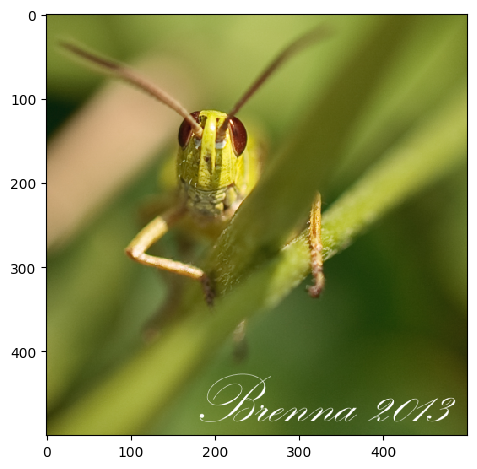

In [4]:
downsampled = rgb_downsample(color_image, kernel_size=2)
_ = io.imshow(downsampled)

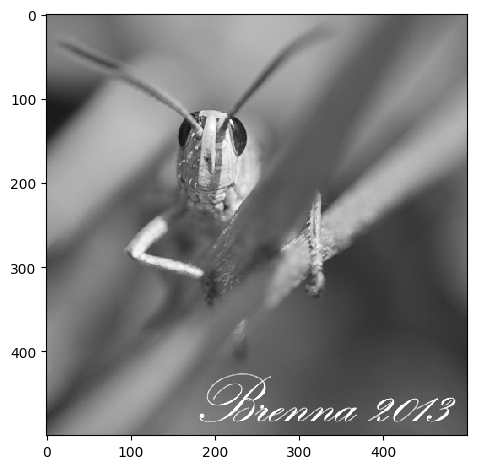

In [5]:
downsampled = nonlinear_downsample(grey_image, kernel_size=2, aggregate=np.max)
_ = io.imshow(downsampled)

# Upsampling

Use naive convolution interpolation to upsample the image by applying interpolation row-wise and then column-wise 

In [6]:
grey_image.shape

(1000, 1000)

In [7]:
%%time

upsampled = image_interpolate1d(grey_image, kernel=kernels.linear_kernel, ratio=2)
upsampled.shape

CPU times: user 11min 8s, sys: 8min 59s, total: 20min 8s
Wall time: 1min 43s


(2000, 2000)

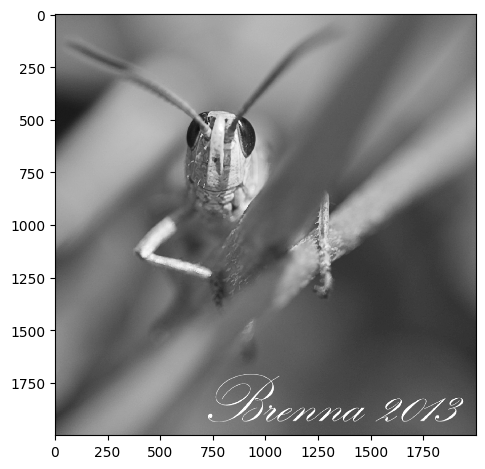

In [8]:
_ = io.imshow(upsampled)

RGB image can be interpolated the same way by applying ineterpolation to each channel

In [9]:
%%time

color_image = transform.resize(color_image, output_shape=(400, 400, 3))  # scale down to avoid long wait time
color_upsampled_image = rgb_image_interpolate(color_image, kernel=kernels.linear_kernel, ratio=2)
color_upsampled_image.shape

CPU times: user 3min 51s, sys: 3min 9s, total: 7min
Wall time: 35.8 s


(800, 800, 3)

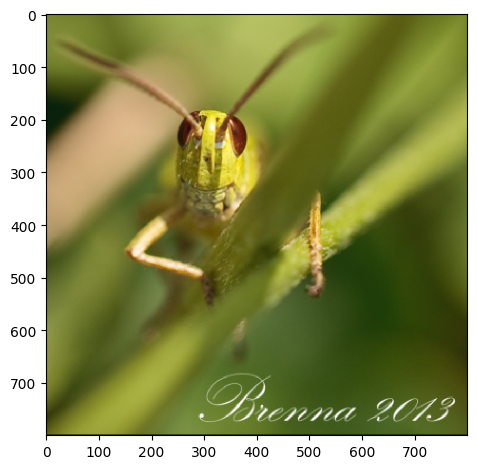

In [10]:
_ = io.imshow(color_upsampled_image)

# Non-Interger Scaling

To perform non-integer scaling upsampling and downsampling needs to be applied in turn, for 1.5 resize, the image can be scaled up 3 times and down 2 times.

In [11]:
image = io.imread(r"../../data/panda.jpg")  # use differnt image
image = transform.resize(image, output_shape=(200, 300, 3))  # scale down, since naive interpolation is quite slow

image.shape

(200, 300, 3)

In [12]:
def ratio_to_fraction(ratio: float) -> tuple[int, int]:
    """Returns denominator and numerator from any float"""
    frac = fractions.Fraction(ratio).limit_denominator()
    return frac.numerator, frac.denominator 


In [13]:
def scale(image: NDArray, ratio: float, kernel: callable) -> NDArray:
    """Scales given image with non-integer ration and given interpolation kernel"""
    upscale, downscale = ratio_to_fraction(ratio)  # upscale and downscale sizes
    color = True if image.ndim == 3 else False

    if color:
        image = rgb_image_interpolate(image, kernel=kernel, ratio=upscale)
        image = rgb_downsample(image, kernel_size=downscale)
    else:
        image = image_interpolate1d(image, kernel=kernel, ratio=upscale)
        image = rgb_downsample(image, kernel_size=downscale)
    
    return image

The scaling function can be applied to RGB images and greyscale for down and upsampling. <br>
It does not scale well, since it is processing sequentially (the `for` loop), so it is not advised to apply to large images.

In [14]:
%%time

scaled = scale(image, ratio=1.5, kernel=kernels.linear_kernel)
scaled.shape

CPU times: user 2min 8s, sys: 1min 45s, total: 3min 54s
Wall time: 20 s


(300, 450, 3)

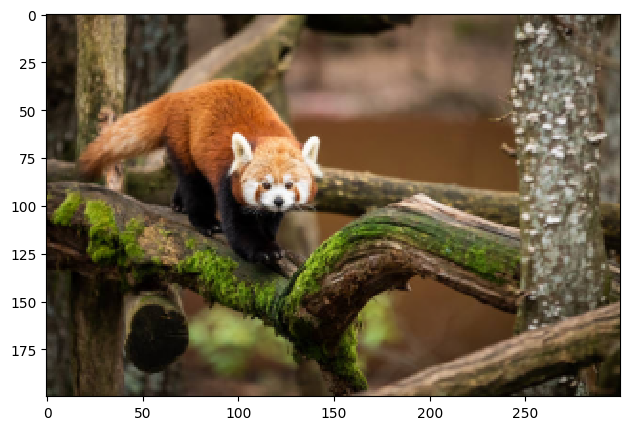

In [15]:
_ = io.imshow(image)

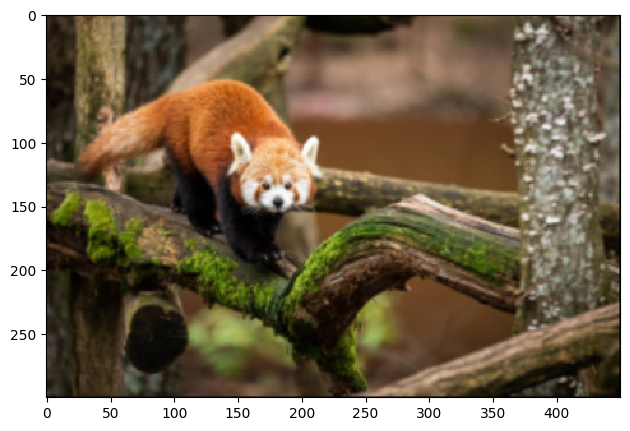

In [16]:
_ = io.imshow(scaled)